In [1]:
import os
from math import *
from time import perf_counter_ns
import gc
from random import choice
import copy
os.chdir('dataset')

# Parse Input

In [2]:
def parse_input_file(file_address):
    # store vertices and edges in separate sets
    vertices = set()
    edges = [] 
    # read file
    with open(file_address) as f:
        lines = f.readlines()
    num_V_E = [int(x) for x in lines[0].split()]
    lines = lines[1:]
    # populate sets
    for line in lines:
        x = line.split()
        vertices.add(x[0])
        vertices.add(x[1])
        edges.append((x[0], x[1], int(x[2])))
    vertices = list(vertices)
    return vertices, edges, num_V_E

In [3]:
graphs = []
for file in os.listdir():
    vertices, edges, num_V_E = parse_input_file(file) 
    graphs.append((num_V_E, vertices, edges))

In [4]:
#graphs #a list of graphs as tuples, the tuples contain: 
#[0]: a list containing number of vertices and edges
#[1]: a list of vertices' names
#[2]: a list of edges as tuples (u,v,w)

# Stoer and Wagner's deterministic algorithm 

In [5]:

def findCut(V,E):
        rV,rW, nV = findMax(V,E) #gets the vertex and all the edges, gives back the weight of the cut, and two last nodes to merge
        if nV != None:
            E,_,_ = updateDict(rV,nV,E) #merges two last nodes and updates edge dictionary
        return rW, E

def findMax(V,E):
    Ecop = copy.deepcopy(E)
    seen = []
    V2 = None
    while(len(Ecop) > 2):                                    # here we want to merge nodes until we reach the 2 last nodes
        highestWeight = Ecop[V][0]                           # so we can get the cut.
        Ecop, V, V2 = updateDict(V,highestWeight[0],Ecop)    # at each iteration we get the node adjacent to starting node with
    remainingVertex = list(Ecop.keys())                      # highest weight and merge it and continue
    remainingWeight = Ecop[remainingVertex[0]][0][1]         # at the end we return the remaining 2 vertices and their
    V1 = remainingVertex[0]                                  # edge's weight
    return V1, remainingWeight, V2

def updateDict(oldTouched,newTouched, EdgeDict, doSort = True):
    list1 = EdgeDict[oldTouched]
    list2 = EdgeDict[newTouched]
    newName = oldTouched+'&'+newTouched                                          # here given two vertices, we merge them and 
    EdgeDict.pop(oldTouched)                                                     # keep track of their adjacent nodes and their
    EdgeDict.pop(newTouched)                                                     # weights, at the end the dictionary will get
    EdgeDict[newName] = []                                                       # updated with refrences to old nodes removed
    for i in range(len(list1)):                                                  
        for j in range(len(list2)):                                              
            if list1[i] == [] or list2[j] == []:
                continue
            if list1[i][0] == oldTouched or list1[i][0] == newTouched:           # these are to skip added nodes
                list1[i] = []                                                    # and mitigate the risk of duplicates
                continue
            if list2[j][0] == oldTouched or list2[j][0] == newTouched:
                list2[j] = []
                continue
            if list1[i][0] == list2[j][0]:                                       # if there are two paths to new merged node
                EdgeDict[newName].append((list1[i][0],list1[i][1]+list2[j][1]))  # simply sum the weights
                list1[i] = []
                list2[j] = []
    
    for i in range(len(list1)):
        if list1[i] == []:
            continue
        EdgeDict[newName].append((list1[i][0],list1[i][1]))                      # if it's not duplicate and there are one path
        list1[i] = []                                                            # simply add them
    for j in range(len(list2)):
        if list2[j] == []:
            continue
        EdgeDict[newName].append((list2[j][0],list2[j][1]))
        list2[j] = []
        
    for u,w in EdgeDict[newName]:
        if u == oldTouched:
            u = newName
        if u == newTouched:
            u = newName
        listOld = EdgeDict[u]
        for i in range(len(listOld)):
            if listOld[i][0] == oldTouched or listOld[i][0] == newTouched:        # now we iterate through adjacent nodes of new
                listOld[i] = (newName,w)                                          # merged node, and we update the refrences and
        listOld = list(dict.fromkeys(listOld))                                    # the weights from other keys of dictionary
        if doSort == True:
            EdgeDict[u] = sorted(listOld,reverse=True, key=lambda e:e[1])
        else:
            EdgeDict[u] = listOld
        EdgeDict = deleteSelfRef(EdgeDict)
    return EdgeDict, newName, newTouched

def deleteSelfRef(EdgeDict):
    for selfName in list(EdgeDict.keys()):         # this is to fix an issue that the updateDict() didn't account for
        listSelf = EdgeDict[selfName]              # when updating the list of adjacency for each node, there might be a
        for i in range(len(listSelf)):             # refrence to the same node in its adjacency list, this will remove the
            if listSelf[i][0] == selfName:         # self reference
                listSelf.pop(i)
                break
    return EdgeDict

def createDict(verticesTuple): #this creates a dictionary with "v" as key and (u,w) as values, also sorts it! for faster access.
    vert = {}
    for (u,v,w) in verticesTuple:
        if u not in vert:
            vert[u] = []
        if v not in vert:
            vert[v] = []
        vert[u].append((v,int(w)))
        vert[v].append((u,int(w)))
    for v in vert:
        vert[v] = sorted(vert[v],reverse=True, key=lambda e:e[1])
    return vert

In [6]:
#start with arbitary vertex
time_weight_Deterministic = []
for graph1 in graphs:
    leftVertices = graph1[0][0]
    NumVert = leftVertices
    NumEdge = graph1[0][1]
    vertices = graph1[1]
    edges = createDict(graph1[2])
    startV = vertices[1]
    cuts=[]
    gc.disable()
    start_time = perf_counter_ns()
    while leftVertices > 2:
        cutWeight, edges = findCut(startV,edges)
        cuts.append(cutWeight)
        leftVertices -= 1
    end_time = perf_counter_ns()
    time = end_time - start_time
    print("for",NumVert,"vertices and",NumEdge,"Edges,","time was:",time,"weight was:",min(cuts))
    time_weight_Deterministic.append((time,NumVert,NumEdge,min(cuts)))
    gc.enable()
#while there is more than one vertex
##find a cut (find a node it's edge to V is maximized, then create a supernode, find a vertex
##that has the highest weight to the super node, go on until we reach the last two! make these a super node!)
##make the graph smaller!(continue what we did last time and store the last weight each time, minimum of them is the min cut)

for 10 vertices and 14 Edges, time was: 3971500 weight was: 3056
for 10 vertices and 10 Edges, time was: 1888600 weight was: 223
for 10 vertices and 12 Edges, time was: 5005200 weight was: 2302
for 10 vertices and 11 Edges, time was: 4819900 weight was: 5152
for 20 vertices and 24 Edges, time was: 22427100 weight was: 1526
for 20 vertices and 24 Edges, time was: 35305300 weight was: 4472
for 20 vertices and 27 Edges, time was: 23548000 weight was: 522
for 20 vertices and 25 Edges, time was: 30185700 weight was: 3210
for 40 vertices and 52 Edges, time was: 132685300 weight was: 2266
for 40 vertices and 54 Edges, time was: 118616400 weight was: 2605
for 40 vertices and 51 Edges, time was: 86858300 weight was: 648
for 40 vertices and 50 Edges, time was: 108923300 weight was: 2486
for 60 vertices and 82 Edges, time was: 387811100 weight was: 1282
for 60 vertices and 72 Edges, time was: 463725400 weight was: 299
for 60 vertices and 83 Edges, time was: 383812500 weight was: 2113
for 60 verti

C estimate: 0.0010248464592483172


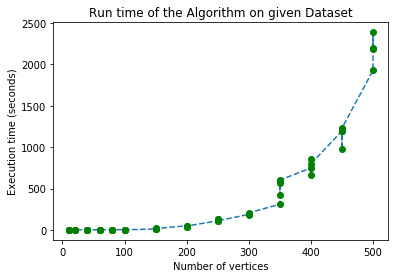

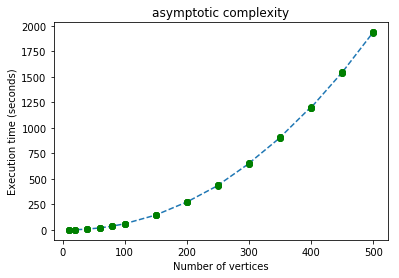

In [28]:
x_val = []
y_val = []
yAC_val = []
c_estimate = []
for (T,V,E,_) in time_weight_Deterministic:
    x_val.append(V)
    y_val.append(T/10**9)
    c_estimate.append((T/10**9) /( V * E + V**2 * log(V)))
    
c = sum(c_estimate)/(len(c_estimate)-40)
print("C estimate:",c)

for (T,V,E,_) in time_weight_Deterministic:
    yAC_val.append(c * (V * E + V**2 * log(V)))

import matplotlib.pyplot as plt
plt.plot(x_val,y_val,'--')
plt.plot(x_val,y_val,'og')
plt.ylabel("Execution time (seconds)")
plt.xlabel("Number of vertices")
plt.title('Run time of the Algorithm on given Dataset')
plt.show()
plt.plot(x_val,yAC_val,'--')
plt.plot(x_val,yAC_val,'og')
plt.xlabel("Number of vertices")
plt.ylabel("Execution time (seconds)")
plt.title("asymptotic complexity")
plt.show()

O(|V||E|+|V|^2*log |V|) stoer wagner

# Karger and Stein's randomized algorithm

In [6]:
def rec_contract(E,N):
    if N <= 6:
        return contract(E,2,N)[0] #only returns weight
    t = ceil((N/sqrt(2))+1)
    W = []
    for i in range(0,1): #technically creating two random instances and using the one with minimum weight
        _,Gi,N = contract(E,t,N)
        W.append(rec_contract(Gi,N))
    return min(W)

In [7]:
def contract(E,T,N):
    while N > T: # instead of a simple contraction that continues until |V| <= 2, a variable is used to reuse the code
        randV = choice(list(E.keys()))
        randE = choice(E[randV])
        E,_,_ = updateDict(randV,randE[0],E,False)
        N -=1
    return E[list(Ecop.keys())[0]][0][1],E,N #a very ugly way to get the weight but it works!
#contraction of an edge:
#while len V > 2
# pick edge from E randomly
# contract E
#return only cut left!

In [8]:
time_weight_Randomized = []
end_current = 0
for graph1 in graphs:
    currentcut = float('inf')
    edges = createDict(graph1[2])
    cuts=[]
    leftVertices = graph1[0][0]
    NumVert = leftVertices
    NumEdge = graph1[0][1]
    gc.disable()
    start_time = perf_counter_ns()
    for i in range(0,ceil(log(leftVertices)**2)): #repeat it for (log(n))**2 times!
        leftVertices = graph1[0][0]
        Ecop = copy.deepcopy(edges)
        w = rec_contract(Ecop,leftVertices)
        cuts.append(w)
        if w < currentcut:
            currentcut = w
            end_current = perf_counter_ns()
            dis_time = end_current - start_time
    end_time = perf_counter_ns()
    time = end_time - start_time
    gc.enable()
    print("for",NumVert,"vertices and",NumEdge,"Edges,","time was:",time,"weight was:",min(cuts),"also dicovery Time was:",dis_time)
    time_weight_Randomized.append((time,dis_time,NumVert,NumEdge,min(cuts)))

for 10 vertices and 14 Edges, time was: 3011900 weight was: 8580 also dicovery Time was: 2054200
for 10 vertices and 10 Edges, time was: 2190200 weight was: 6077 also dicovery Time was: 1108000
for 10 vertices and 12 Edges, time was: 7674900 weight was: 2302 also dicovery Time was: 7673000
for 10 vertices and 11 Edges, time was: 6537700 weight was: 5152 also dicovery Time was: 2300300
for 20 vertices and 24 Edges, time was: 49439400 weight was: 6668 also dicovery Time was: 10619500
for 20 vertices and 24 Edges, time was: 32815500 weight was: 7009 also dicovery Time was: 26316800
for 20 vertices and 27 Edges, time was: 41051400 weight was: 936 also dicovery Time was: 29844300
for 20 vertices and 25 Edges, time was: 60233700 weight was: 3250 also dicovery Time was: 60232100
for 40 vertices and 52 Edges, time was: 67978600 weight was: 2266 also dicovery Time was: 24745300
for 40 vertices and 54 Edges, time was: 99970800 weight was: 1446 also dicovery Time was: 85501500
for 40 vertices and

C estimate: 8.74783436626225e-07


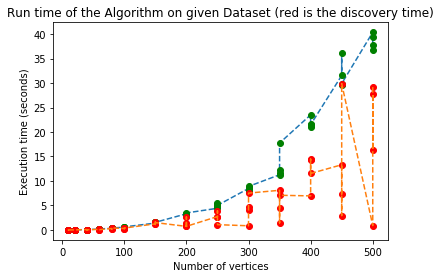

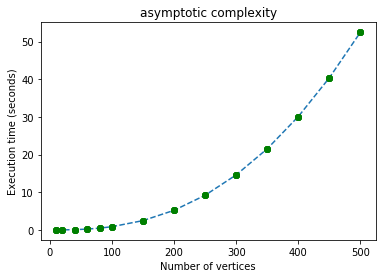

In [44]:
x_val = []
y_val = []
dis_val = []
yAC_val = []
c_estimate = []
for (T,Td,V,E,_) in time_weight_Randomized:
    x_val.append(V)
    y_val.append(T/10**9)
    dis_val.append(Td/10**9)
    c_estimate.append((T/10**9) /((V**2 * (log(V)**3))))
    
c = sum(c_estimate)/(len(c_estimate))
print("C estimate:",c)

for (T,Td,V,E,_) in time_weight_Randomized:
    yAC_val.append(c * (V**2 * (log(V)**3)))

import matplotlib.pyplot as plt
plt.plot(x_val,y_val,'--')
plt.plot(x_val,y_val,'og')
plt.plot(x_val,dis_val,'or')
plt.plot(x_val,dis_val,'--')
plt.ylabel("Execution time (seconds)")
plt.xlabel("Number of vertices")
plt.title('Run time of the Algorithm on given Dataset (red is the discovery time)')
plt.show()
plt.plot(x_val,yAC_val,'--')
plt.plot(x_val,yAC_val,'og')
plt.xlabel("Number of vertices")
plt.ylabel("Execution time (seconds)")
plt.title("asymptotic complexity")
plt.show()

O(n^2 * log n)